# *Библиотеки*

In [ ]:
!pip install pytorch_lightning
!pip install torchmetrics

In [ ]:
import torch 
import torchvision 
from torch import nn
from torchvision.datasets import StanfordCars
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import albumentations as A

In [ ]:
!pip install pytorch_lightning
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 800 kB 7.6 MB/s 
     |████████████████████████████████| 125 kB 27.1 MB/s 
     |████████████████████████████████| 512 kB 55.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pytorch_lightning as pl
from torchmetrics.functional.classification import accuracy

# Данные

In [ ]:
transform=T.Compose(
        [
            T.Resize((224, 224)), 
            T.ToTensor(), 
            T.Normalize((0.5, 0.5, 0.5), (1, 1, 1)), 
        ]
    )

In [ ]:
train_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
train_set = StanfordCars('.StanfordCars', split = 'train', transform=transform, download=True)
test_set = StanfordCars('.StanfordCars', split = 'test', transform=transform, download=True)

  0%|          | 0/330960 [00:00<?, ?it/s]

Extracting .StanfordCars/stanford_cars/car_devkit.tgz to .StanfordCars/stanford_cars


  0%|          | 0/979269282 [00:00<?, ?it/s]

Extracting .StanfordCars/stanford_cars/cars_train.tgz to .StanfordCars/stanford_cars
Using downloaded and verified file: .StanfordCars/stanford_cars/car_devkit.tgz
Extracting .StanfordCars/stanford_cars/car_devkit.tgz to .StanfordCars/stanford_cars


  0%|          | 0/977350468 [00:00<?, ?it/s]

Extracting .StanfordCars/stanford_cars/cars_test.tgz to .StanfordCars/stanford_cars


  0%|          | 0/185758 [00:00<?, ?it/s]

In [ ]:
train_loader = DataLoader(train_set, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# Модель

### AlexNet

In [ ]:
from torchvision.models import alexnet

In [ ]:
model = alexnet(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
sum(param.numel() for param in model.parameters()) # 61_000_000

61100840

In [ ]:
class Cars(pl.LightningModule):
  def __init__(self, pretrained:bool = True):
    super().__init__()
    self.pretrained = pretrained

    if pretrained:
      self.model = alexnet(pretrained=True)
      self.model.fc = nn.Identity()
      self.classifier = nn.Linear(1000, 196)
      self.optimizer =torch.optim.Adam(self.classifier.parameters())
    else:
      self.model = alexnet()
      self.model.fc = nn.Identity()
      self.classifier = nn.Linear(1000, 196)
      self.optimizer = torch.optim.Adam(self.model.parameters())
    self.loss = nn.CrossEntropyLoss()
  def forward(self, x) -> torch.Tensor:
    if self.pretrained:
      with torch.no_grad():
        features = self.model(x)
      preds = self.classifier(features)
    else:
      preds = self.model(x)

    return preds
  
  def configure_optimizers(self):
    return self.optimizer
  def training_step(self, train_batch, batch_idx) -> torch.Tensor:
    images, target = train_batch
    preds = self.forward(images)
    loss = self.loss(preds, target)
    self.log('train_loss', loss, prog_bar =True)
    return loss

  def validation_step(self, val_batch, batch_idx) -> torch.Tensor:
    images, target = val_batch
    preds = self.forward(images)
    loss = self.loss(preds, target)
    acc = accuracy(preds, target,task='multiclass', num_classes=196,average="micro")
    self.log("val_loss", loss, prog_bar=True)
    self.log("accuracy", acc, prog_bar=True)





In [ ]:
Car = Cars(pretrained=True)

trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=10
)
trainer.fit(Car, train_loader, test_loader)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - 

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


### ResNet34

In [ ]:
import torchvision.models as models
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 196)
model_ft = model_ft.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
class Cars(pl.LightningModule):
  def __init__(self, pretrained:bool = True):
    super().__init__()
    self.pretrained = pretrained

    if pretrained:
      self.model = models.resnet34(pretrained=True)
      self.model.fc = nn.Identity()
      num_ftrs = model_ft.fc.in_features
      self.classifier = nn.Linear(num_ftrs, 196)
      self.optimizer =torch.optim.Adam(self.classifier.parameters())
    else:
      self.model = models.resnet34()
      num_ftrs = model_ft.fc.in_features
      self.classifier = nn.Linear(num_ftrs, 196)
      self.optimizer = torch.optim.Adam(self.model.parameters())
    self.loss = nn.CrossEntropyLoss()
  def forward(self, x) -> torch.Tensor:
    if self.pretrained:
      with torch.no_grad():
        features = self.model(x)
      preds = self.classifier(features)
    else:
      preds = self.model(x)

    return preds
  
  def configure_optimizers(self):
    return self.optimizer
  def training_step(self, train_batch, batch_idx) -> torch.Tensor:
    images, target = train_batch
    preds = self.forward(images)
    loss = self.loss(preds, target)
    self.log('train_loss', loss, prog_bar =True)
    return loss

  def validation_step(self, val_batch, batch_idx) -> torch.Tensor:
    images, target = val_batch
    preds = self.forward(images)
    loss = self.loss(preds, target)
    acc = accuracy(preds, target,task='multiclass', num_classes=196,average="micro")
    self.log("val_loss", loss, prog_bar=True)
    self.log("accuracy", acc, prog_bar=True)

In [ ]:
Car = Cars(pretrained=True)

trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=10
)
trainer.fit(Car, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params
------------------------------------------------
0 | model      | ResNet           | 21.3 M
1 | classifier | Linear           | 100 K 
2 | loss       | CrossEntropyLoss | 0     
------------------------------------------------
21.4 M    Trainable params
0         Non-trainable params
21.4 M    Total params
85.541    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

In [ ]:
Car = Cars(pretrained=True)

trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=100
)
trainer.fit(Car, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params
------------------------------------------------
0 | model      | ResNet           | 21.3 M
1 | classifier | Linear           | 100 K 
2 | loss       | CrossEntropyLoss | 0     
------------------------------------------------
21.4 M    Trainable params
0         Non-trainable params
21.4 M    Total params
85.541    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Интерактивная визуализация

In [ ]:
from IPython.display import clear_output
from tqdm.notebook import tqdm
def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()


def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy

def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step(train_accuracy)

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

    return train_losses, test_losses, train_accuracies, test_accuracies

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device
num_epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

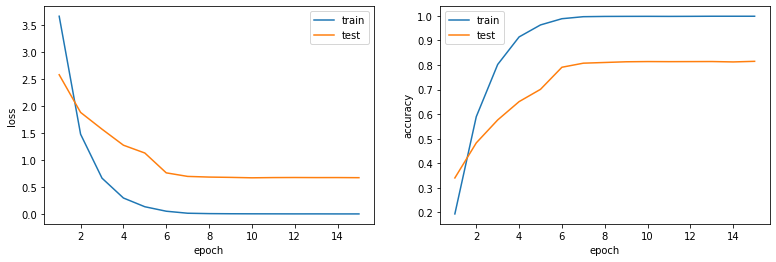

In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model_ft, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [ ]:
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/Colab Notebooks/state_dict_model.pt')